In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split

Apply augmentation only on Positive Samples

In [2]:
# Function for preprocessing data with audio augmentation
def preprocess_data_with_augmentation(file_path, max_time_steps=109, sample_rate=16000, duration=3, n_mels=80):
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

    # Apply data augmentation
    pitch_shifted_audio = librosa.effects.pitch_shift(audio,sr=sample_rate, n_steps=np.random.uniform(-2, 2))
    time_stretched_audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    amplitude_scaled_audio = audio * np.random.uniform(0.5, 1.5)

    augmented_audios = [audio, pitch_shifted_audio, time_stretched_audio, amplitude_scaled_audio]

    mel_spectrograms = []

    for augmented_audio in augmented_audios:
        # Extract Mel spectrogram using librosa
        mel_spectrogram = librosa.feature.melspectrogram(y=augmented_audio, sr=sample_rate, n_mels=n_mels)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Ensure all spectrograms have the same width (time steps)
        if mel_spectrogram.shape[1] < max_time_steps:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :max_time_steps]

        mel_spectrograms.append(mel_spectrogram)

    return mel_spectrograms

In [7]:
# Set your file paths and constants
TRAINING_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
TRAINING_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
VALIDATION_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac'
VALIDATION_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
SAMPLE_RATE = 16000  # Adjust if your sample rate is different
DURATION = 3  # Adjust the duration of your audio samples
N_MELS = 80  # Adjust the number of mel filters
max_time_steps = 109 

In [4]:
# Load labels for training Data
if os.path.exists('labels/X_train_MEL.npy') and os.path.exists('labels/y_train_MEL.npy'):
    X = np.load('labels/X_train_MEL.npy')
    y = np.load('labels/y_train_MEL.npy')
else:
    train_labels = {}

    with open(TRAINING_LABEL, 'r') as label_file:
        lines = label_file.readlines()

    for line in lines:
        parts = line.strip().split()
        file_name = parts[1]
        label = 1 if parts[-1] == "bonafide" else 0
        train_labels[file_name] = label

    X = []
    y = []

 # Define the maximum time steps for your model

    for file_name, label in train_labels.items():
        file_path = os.path.join(TRAINING_DATA, file_name + ".flac")

        # Use the preprocess_data function
        mel_spectrogram = preprocess_data_with_augmentation(file_path, max_time_steps=max_time_steps)

        X.append(mel_spectrogram)
        y.append(label)
        y.append(label)
        y.append(label)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Save the preprocessed data
    np.save('labels/X_train_MEL.npy', X)
    np.save('labels/y_train_MEL.npy', y)


In [8]:
# Print out the shapes for debugging
print("Shape of X before reshape:", X.shape)
print("Shape of y before reshape:", y.shape)

# Reshape input data to match the required input shape for ResNet
X_new = X.reshape((X.shape[0]*4, N_MELS, max_time_steps, 1))

print(X_new.shape)

Shape of X before reshape: (25380, 4, 80, 109)
Shape of y before reshape: (101520,)
(101520, 80, 109, 1)


In [9]:
# Define input shape and number of classes
input_shape = X[0].shape
num_classes = 2  # Assuming you have two classes (0 and 1)

In [14]:
# Load and preprocess evaluation data
if os.path.exists('labels/val_X_MEL.npy') and os.path.exists('labels/val_y_MEL.npy'):
    eval_X = np.load('labels/val_X_MEL.npy')
    eval_y = np.load('labels/val_y_MEL.npy')
else:
    eval_X = []
    eval_y = []

    with open(VALIDATION_LABEL, 'r') as eval_label_file:
        eval_lines = eval_label_file.readlines()

    eval_labels = {}

    for line in eval_lines:
        parts = line.strip().split()
        file_name = parts[1]
        label = 1 if parts[-1] == "bonafide" else 0
        eval_labels[file_name] = label

    for file_name, label in eval_labels.items():
        file_path = os.path.join(VALIDATION_DATA, file_name + ".flac")

        # Use the preprocess_data function
        mel_spectrogram = preprocess_data_with_augmentation(file_path, max_time_steps=max_time_steps)

        eval_X.append(mel_spectrogram)
        eval_y.append(label)
        eval_y.append(label)
        eval_y.append(label)
        eval_y.append(label)

    eval_X = np.array(eval_X)
    eval_y = np.array(eval_y)

    # Save the preprocessed data
    np.save('labels/val_X_MEL.npy', eval_X)
    np.save('labels/val_y_MEL.npy', eval_y)


In [15]:
# Print out the shapes for debugging
print("Shape of eval_X before reshape:", eval_X.shape)
print("Shape of eval_y before reshape:", eval_y.shape)

eval_X_reshaped = eval_X.reshape((eval_X.shape[0] * 4, N_MELS, max_time_steps, 1))

print(eval_X_reshaped.shape)

Shape of eval_X before reshape: (24844, 4, 80, 109)
Shape of eval_y before reshape: (99376,)
(99376, 80, 109, 1)


In [26]:
from tensorflow.keras import layers, models

def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(stride, stride))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, (kernel_size, kernel_size), strides=(stride, stride), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # ResNet blocks
    for size in [64, 128, 256, 512]:
        x = resnet_block(x, size, conv_shortcut=True)
        x = resnet_block(x, size)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x, name='resnet_model')
    return model

In [27]:
num_classes=2

# Assuming input_shape is defined as the shape of one sample in your data
input_shape = (80, 109, 1)

# Build the model
model = build_resnet(input_shape=input_shape, num_classes=num_classes)

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [29]:
# Display the model summary
model.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80, 109, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 40, 55, 64)   3200        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 40, 55, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [31]:
# Train the model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in zip(np.unique(y_train), class_weights)}

print(class_weights_dict)


{0: 0.5566247224278312, 1: 4.915032679738562}


In [32]:
# Train the model with audio data augmentation
NUM_EPOCHS = 50
BATCH_SIZE = 64
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                            validation_data=(eval_X_reshaped, eval_y), class_weight = class_weights_dict, callbacks=[early_stopping])

Epoch 1/50


2023-11-16 03:58:07.262597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-11-16 03:58:07.786520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1269/1269 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9141

2023-11-16 04:00:16.498256: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3466234880 exceeds 10% of free system memory.
2023-11-16 04:00:18.955748: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3466234880 exceeds 10% of free system memory.


1269/1269 [==============================] - 191s 147ms/step - loss: 0.1879 - accuracy: 0.9141 - val_loss: 1.6244 - val_accuracy: 0.6056
Epoch 2/50
1269/1269 [==============================] - 185s 146ms/step - loss: 0.0643 - accuracy: 0.9756 - val_loss: 1.5514 - val_accuracy: 0.8974
Epoch 3/50
1269/1269 [==============================] - 186s 146ms/step - loss: 0.0515 - accuracy: 0.9807 - val_loss: 0.5221 - val_accuracy: 0.8332
Epoch 4/50
1269/1269 [==============================] - 186s 147ms/step - loss: 0.0374 - accuracy: 0.9863 - val_loss: 0.1616 - val_accuracy: 0.9618
Epoch 5/50
1269/1269 [==============================] - 186s 147ms/step - loss: 0.0311 - accuracy: 0.9883 - val_loss: 0.1498 - val_accuracy: 0.9531
Epoch 6/50
1269/1269 [==============================] - 186s 146ms/step - loss: 0.0233 - accuracy: 0.9916 - val_loss: 0.4749 - val_accuracy: 0.9208
Epoch 7/50
1269/1269 [==============================] - 186s 147ms/step - loss: 0.0198 - accuracy: 0.9925 - val_loss: 0.052

In [33]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Evaluate the model on the separate evaluation dataset
eval_loss, eval_accuracy = model.evaluate(eval_X_reshaped, eval_y)
print(f'Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy * 100:.2f}%')

635/635 [==============================] - 14s 21ms/step - loss: 0.0063 - accuracy: 0.9976
Test Loss: 0.0063, Test Accuracy: 99.76%


2023-11-16 05:21:28.652213: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3466234880 exceeds 10% of free system memory.
2023-11-16 05:21:31.023296: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3466234880 exceeds 10% of free system memory.


3106/3106 [==============================] - 66s 21ms/step - loss: 0.0338 - accuracy: 0.9905
Evaluation Loss: 0.0338, Evaluation Accuracy: 99.05%


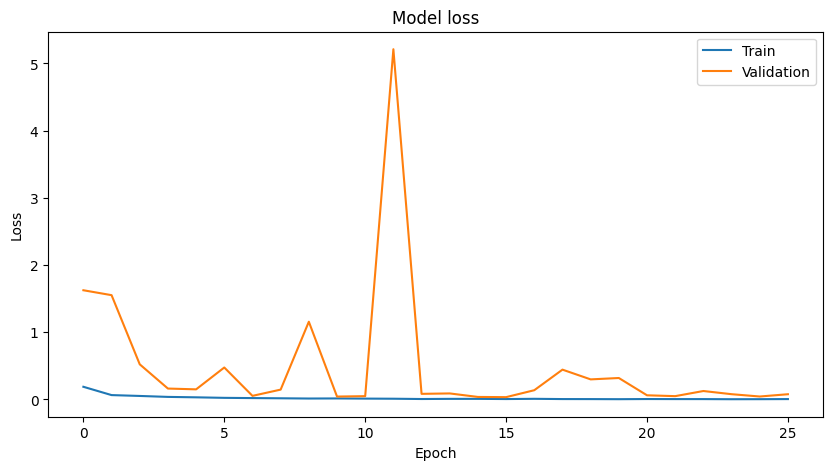

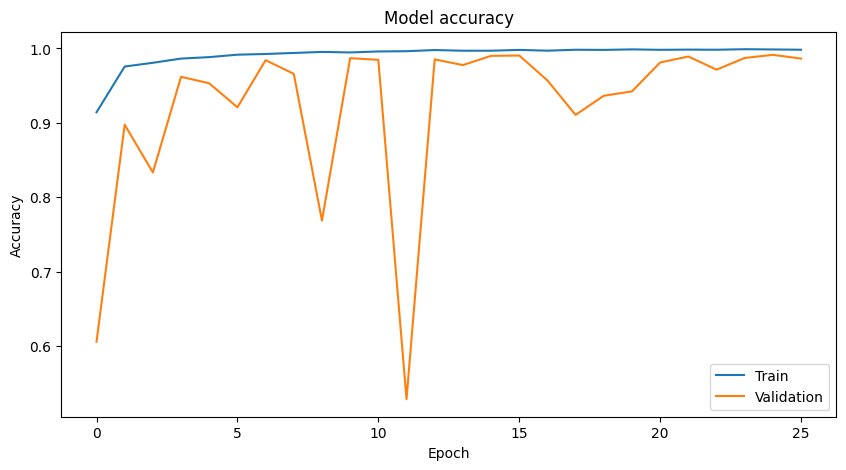

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Save the trained model
model.save("models/weighted_loss_augmentation.h5")